Import of all relevant dependencies

In [11]:
%load_ext tensorboard
#%tensorboard --logdir logs

import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torchvision.models as models  
import torchvision.datasets as datasets
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
import seaborn as sn

writer = SummaryWriter('logs/' + str(np.random.randint(0,100000)))
writer.close()

#show tensorboard 
from tensorboard import notebook
%tensorboard --logdir logs
notebook.list() # View open TensorBoard instances
# notebook.display(port=6006, height=1000) 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 539), started 0:45:59 ago. (Use '!kill 539' to kill it.)

<IPython.core.display.Javascript object>

Known TensorBoard instances:
  - port 6006: logdir logs (started 0:45:59 ago; pid 539)


Load Resnet18 and necessary transformers for training and test set

In [2]:
#Resnet was pre-trained on imageNet with 1000 classes
resnet18 = models.resnet18(pretrained=True)
writer.add_graph(resnet18, torch.zeros([64, 3, 7, 7]))

#transformation with augmentation and CIFAR10 normalization, for training and test set
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=8, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

Load CIFAR 10 training and test set.

In [3]:
#cifar10 training and test set with a dataloader
trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=transform_train)
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)

testset = datasets.CIFAR10(root='.', train=False, download=True, transform=transform_test)
classes = testset.classes
testLoader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


Plot some samples to get a sense of how they look.

In [4]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
def show_batch(dl):
  for images, label in dl:
    fig, ax = plt.subplots(figsize=(10, 10))
    image_grid = make_grid(images, 10)
    plt.close()
    writer.add_image('Data samples', image_grid)
    break

show_batch(trainLoader)
show_batch(testLoader)

Get working device.

In [5]:
def get_default_device():
  return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(obj, device):
  if isinstance(obj, (list, tuple)):
    return [to_device(x, device) for x in obj]
  
  return obj.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, dataloader, device):
    self.dl = dataloader
    self.device = device

  def __iter__(self):
    for cell in self.dl:
      yield to_device(cell, self.device)
  
  def __len__(self):
    return len(self.dl)
  
device = get_default_device()
trainLoader = DeviceDataLoader(trainLoader, device)
testLoader = DeviceDataLoader(testLoader, device)

Load the resnet18 model into a new model class.

In [6]:
class Model(nn.Module):
    def __init__(self, _resnet18):
        super(Model, self).__init__()
        self.conv = _resnet18.conv1
        self.first_block = _resnet18.layer1
        self.second_block = _resnet18.layer2
        self.third_block = _resnet18.layer3
        self.fourth_block = _resnet18.layer4
        self.max_pooling = _resnet18.maxpool
        self.avg_pooling = _resnet18.avgpool
        self.batchnorm = _resnet18.bn1
        self.fc = nn.Linear(_resnet18.fc.in_features, 10)
        self.dropout = nn.Dropout(p=0.3)
        self.ReLU = nn.ReLU()
        self.flatten = nn.Flatten()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.ReLU(x)
        x = self.max_pooling(x)
        x = self.first_block(x)
        x = self.second_block(x)
        x = self.third_block(x)
        x = self.fourth_block(x)
        x = self.avg_pooling(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc(x)
        x = self.softmax(x)

        return x

class ChooserModel(nn.Module):
    def __init__(self):
        super(ChooserModel, self).__init__()
        self.fc1 = nn.Linear(30, 10)
        self.fc2 = nn.Linear(10, 10)
        self.dropout = nn.Dropout(p=0.3)
        self.ReLU = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.ReLU(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [7]:
# To increase certainty, I have made an ensemble of 3 models and added a "chooser"
# network, simple MLP which takes the concatenated output of the ensemble and outputs 
# a final choice.

for param_num, param in enumerate(resnet18.parameters()):
  if param_num > 0.5 * len(list(resnet18.parameters())):
    param.requires_grad = True
  else:
    param.requires_grad = False

model_dict = {'model1': to_device(Model(resnet18), device), 
              'model2': to_device(Model(resnet18), device), 
              'model3': to_device(Model(resnet18), device),
              'chooser': to_device(ChooserModel(), device)}

Initialize summary writer for log and define criterion and optimizer.

In [8]:
epochs = 100
max_lr = 1e-2
criterion = nn.CrossEntropyLoss()

p = (set(model_dict['model1'].parameters()) |
     set(model_dict['model2'].parameters()) |
     set(model_dict['model3'].parameters()) |
     set(model_dict['chooser'].parameters()))

optimizer = optim.Adam(p, lr=max_lr, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs * len(trainLoader))

Define accuracy metrics, train & test loops.

In [9]:
def accuracy(predictions, labels):
  predictions, class_id = torch.max(predictions, dim=1)
  return torch.tensor(torch.sum(class_id == labels).item() / len(labels))

def confusion_matrix(labels, predictions, epoch, categories, accuracy):
    data = {'y_Actual': labels,
            'y_Predicted': predictions}

    df = pd.DataFrame(data, columns=['y_Actual', 'y_Predicted'])
    confusion = pd.crosstab(df['y_Actual'], df['y_Predicted'],
                            rownames=['Actual'], colnames=['Predicted'],
                            margins=True)

    for _key in confusion:
        confusion[_key] = confusion[_key] / confusion[_key]['All']

    heatmap = sn.heatmap(confusion.iloc[0:-1, 0:-1], annot=True,
                         xticklabels=categories, yticklabels=categories,
                         vmax=1, vmin=0)
    plt.title(f'Epoch - {epoch + 1}, Test accuracy - {accuracy*100:.2f}%')
    plt.tight_layout(pad=3.0)
    plt.show()

def train_loop(model_dict, _criterion, dataLoader, _epoch):
  for key in model_dict:
    model_dict[key].train()

  batch_loss = []
  print('   Training:')
  for i, data in enumerate(tqdm(dataLoader)):      
      inputs, labels = data
      optimizer.zero_grad()

      for ii, key in enumerate(model_dict):
        if key != 'chooser':
          if ii == 0:
            outputs = model_dict[key](inputs)
          else:
            outputs = torch.cat([outputs, model_dict[key](inputs)], dim=1)
      
      outputs = model_dict['chooser'](outputs)

      loss = _criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      scheduler.step()
      batch_loss.append(loss)
  
  return torch.stack(batch_loss).mean()

def eveluation_loop(model_dict, _criterion, dataLoader, _epoch):
  for key in model_dict:
    model_dict[key].eval()
  
  batch_loss = []
  batch_accuracy = []
  print('   Testing:')
  for i, data in enumerate(tqdm(dataLoader)):     
      inputs, labels = data
      with torch.no_grad():
        for ii, key in enumerate(model_dict):
          if key != 'chooser':
            if ii == 0:
              outputs = model_dict[key](inputs)
            else:
              outputs = torch.cat([outputs, model_dict[key](inputs)], dim=1)
        
        outputs = model_dict['chooser'](outputs)

        if i == 0:
          all_labels = labels
          all_outputs = outputs
        else:
          torch.cat([all_labels, labels])
          torch.cat([all_outputs, outputs])

        loss = _criterion(outputs, labels)

        acc = accuracy(outputs, labels)
        batch_accuracy.append(acc)
        batch_loss.append(loss)
  confusion_matrix(all_labels.tolist(), torch.argmax(all_outputs, dim=1).tolist(),
                   _epoch, classes, torch.stack(batch_accuracy).mean() .item())
  
  return torch.stack(batch_loss).mean(), torch.stack(batch_accuracy).mean() 


  0%|          | 0/100 [00:00<?, ?it/s]

   Training:


  0%|          | 0/1562 [00:00<?, ?it/s]

   Testing:


  0%|          | 0/100 [00:00<?, ?it/s]

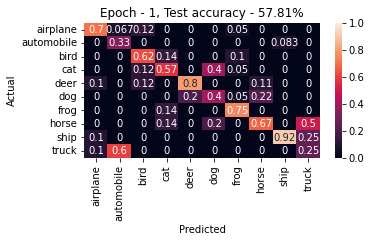

epoch 1/100,    {'accuracy': 57.809996604919434, 'test_loss': 1.2897708415985107, 'train_loss': 1.6306102275848389}
   Training:


  0%|          | 0/1562 [00:00<?, ?it/s]

In [ ]:
results = []

for epoch in tqdm(range(epochs)):
  epoch_train_loss = train_loop(model_dict, criterion, trainLoader, epoch)
  epoch_test_loss, epoch_accuracy = eveluation_loop(model_dict, criterion, testLoader, epoch)

  result = {'accuracy': epoch_accuracy.item() * 100.,
            'test_loss': epoch_test_loss.item(),
            'train_loss': epoch_train_loss.item()}
  results.append(result)
  print(f'epoch {epoch + 1}/{epochs},    {result}')

  writer.add_scalar('Loss\Train', epoch_train_loss, epoch)
  writer.add_scalar('Loss\Test', epoch_test_loss, epoch)
  writer.add_scalar('Accuracy', epoch_accuracy * 100., epoch)